In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
drive.mount("/content/gdrive")  
!pwd  # show current path 

%cd "/content/gdrive/MyDrive/IA95022"
!ls  # show current directory

Mounted at /content/gdrive
/content
/content/gdrive/MyDrive/IA95022
 bezdekIris.data	      notebookdc8e90834b.ipynb
 class_060922_starter.ipynb  'Store Sales'
 DryBeanDataset		      train.csv
 Index			      tutorial_checkpoints
 Indicadores.csv	      tutorial_checkpoints_best
 Indicadores.xlsx	      us2022q2a.csv
 iris.data		      usfirms2022.csv
 iris.names		      Wine
'Modulo 4'


# Carga de datos (importado del entregable anterior)

In [3]:
# Carga de datos
usdata = pd.read_csv('us2022q2a.csv')
usfirms = pd.read_csv('usfirms2022.csv')
# Unimos la información de ambos datasets en un solo dataframe
usfirms.columns = usfirms.columns.str.replace('Ticker', 'firm')
df = pd.merge(usfirms, usdata, on="firm")

# Se obtienen los valores calculados 
df['qdate'] = pd.PeriodIndex(df['q'], freq="Q")
df.set_index(['firm', 'qdate'], drop = True)
df = df.replace(0,np.nan)
df['lprice'] = df.groupby(['firm'])['adjprice'].shift(4)
df['r'] = np.log(df['adjprice']) - np.log(df['lprice'])
df['r2']= np.log(df['adjprice']) - np.log(df.groupby(['firm'])['adjprice'].shift(4))
df.loc['ADT': 'ADTN', ['adjprice', 'lprice', 'r', 'r2']].iloc[85:96,]
df[['q', 'adjprice', 'lprice']]
df.loc['ADT': 'ADTN', ['adjprice', 'lprice']].iloc[84:98]
df["ReturnOnNextQuarter"] = df.groupby(["firm"])["r2"].shift(-1)
# Calculamos las variables para cada instancia de los datos
df['Book'] = df['totalassets'] - df['totalliabilities']
df['Market'] = df['originalprice'] * df['sharesoutstanding']
df["Ebit"] = df["revenue"] - df["cogs"] - df["sgae"] - df["otheropexp"]
df["OPM"] = df["Ebit"] / df["revenue"]
df["Net income"] = df["Ebit"] - df["incometax"] - df["finexp"]
df["Profit margin"] = df["Net income"] / df["revenue"]

df = df.replace(np.nan,0)


In [4]:
from scipy.stats.mstats import winsorize
# Seleccionamos solo los valores que nos serán de utilidad en este análisis
rslt_df = df.loc[df["Sector NAICS\nlevel 1"].isin(['Finance and Insurance', 'Real Estate and Rental and Leasing'  ])]
df_analysis = rslt_df[['firm','q','r2', 'originalprice', 'ReturnOnNextQuarter', 'cogs', 'sgae', 'otheropexp', 'revenue', 'Ebit','OPM', 'Book', 'Market', 'Profit margin']]
mask = df_analysis['q']=='2022q1' 
df_analysis = df_analysis[mask]
# Calculamos las nuevas variables 
#primero llenamos los NaN en todos los valores nulos en los divisores
df = df.replace(0,np.nan)
df_analysis = df_analysis.replace(0,np.nan)

df_analysis["Ebit"] = df["Ebit"].fillna(0)
df_analysis["OPM"] = df["Ebit"] / df["revenue"]
df_analysis['BookToMarketRatio'] = df['Book'] / df['Market']
df_analysis['ShortFinancialLeverage'] = df["shortdebt"] / df["totalassets"] 
df_analysis['LongFinancialLeverage'] = df["longdebt"] / df["totalassets"] 
df_analysis['OperatingProfitGrowth'] = (df["Ebit"] - df["Ebit"].shift(4)) - 1
df_analysis['SalesAnnualGrowth'] = (df["revenue"] / df["revenue"].shift(4)) - 1 
df_analysis['EPS'] = df["Net income"] / df["sharesoutstanding"]
df_analysis["lprice"] = df["lprice"]
df_analysis['EPSP'] =  df_analysis["EPS"] / df_analysis["originalprice"]
df_analysis['Size'] =  df["Market"] 

# Aplicamos la winzorización a nuestros ratios
df_analysis["OPM"] = winsorize(df_analysis["OPM"], limits=[0.0001, 0.02])
df_analysis["BookToMarketRatio"] = winsorize(df_analysis["BookToMarketRatio"], limits=[0.0001, 0.02])
df_analysis["ShortFinancialLeverage"] = winsorize(df_analysis["ShortFinancialLeverage"], limits=[0.0001, 0.02])
df_analysis["OperatingProfitGrowth"] = winsorize(df_analysis["OperatingProfitGrowth"], limits=[0.0001, 0.02])
df_analysis["EPSP"] = winsorize(df_analysis["EPSP"], limits=[0.0001, 0.02])
df_analysis["OperatingProfitGrowth"] = winsorize(df_analysis["OperatingProfitGrowth"], limits=[0.0001, 0.02])
df_analysis["SalesAnnualGrowth"] = winsorize(df_analysis["SalesAnnualGrowth"], limits=[0.0001, 0.02])

df_analysis = df_analysis.replace(np.nan,0)

In [5]:
# En este código lo que se hace es regresar el valor del percentil con respecto al set de datos que recibe la función.
# Esta función va a recibir uno por uno cada quarter, lo que nos hara que regrese el valor del percentil para cada instancia 
# CON RESPECTO A SU QUARTER, NO CON RESPECTO A TODO EL SET DE DATOS

def dense_inclusive_pct(x):
    r = x.rank(method='dense') - 1
    return r / r.max() * 100

# Aqui mandamos a llamar dicha funcion de tal forma que se llame para cada quarter
df_analysis["pct"]=df_analysis.groupby('q').Market.apply(dense_inclusive_pct).astype(int)
# Aqui genero las variables dummies en base a lo mencionado previamente.
df_analysis["small?"] = df_analysis.pct <= 33
df_analysis["small?"] = df_analysis["small?"].astype(int)
df_analysis["medium?"] = (df_analysis.pct <= 66) & (df_analysis.pct > 33) 
df_analysis["medium?"] = df_analysis["medium?"].astype(int)

In [6]:
df_analysis.columns

Index(['firm', 'q', 'r2', 'originalprice', 'ReturnOnNextQuarter', 'cogs',
       'sgae', 'otheropexp', 'revenue', 'Ebit', 'OPM', 'Book', 'Market',
       'Profit margin', 'BookToMarketRatio', 'ShortFinancialLeverage',
       'LongFinancialLeverage', 'OperatingProfitGrowth', 'SalesAnnualGrowth',
       'EPS', 'lprice', 'EPSP', 'Size', 'pct', 'small?', 'medium?'],
      dtype='object')

In [7]:

#add constant to predictor variables
X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]

y = df_analysis["ReturnOnNextQuarter"]

# Análisis exploratorio de las variables


## Matriz de varianza y covarianza

La varianza es una medida de dispersión que nos indica que tanto cambia un conjunto de datos comparado con su promedio. Nos es muy útil para darnos una idea del poder explicativo del promedio, ya que si la varianza es baja entonces el promedio nos da una imagen muy clara de qué podemos obtener al tomar cualquier valor del set de datos.

La covarianza se obtiene al aplicar este concepto comparando dos conjuntos diferentes de datos. Nos ayuda a contestar preguntas como: ¿Qué pasa con X cuando Y incrementa? 

A continuación, se obtendrá una matriz que incluya los valores de la varianza y covarianza obtenidos al comparar entre sí las distintas variables en nuestro set de datos.

In [8]:
#Implementamos manualmente la obtención de la matriz de varianza y covarianza
import numpy as np
def matriz_var_cov(X):
  #Obtenemos la diferencia entre X y su promedio
  X-= X.mean(axis=1)[:,None]
  #Guardamos la cantidad de filas/instancias de datos en una variable
  N = X.shape[1] - 1
  #Ahora utilizaremos una fórmula de álgebra matricial para obtener las varianzas y covarianzas.
  #Tomaremos la matriz de diferencias con el promedio y la transpondremos. Después, obtenemos su 
  #complex conjugate.  
  #Después obtendremos el producto punto de la matriz de diferencias y la matriz calculada previamente.
  #El resultado lo dividiremos entre la cantidad de datos, y habremos obtenido la matriz de varianzas y covarianzas 
  return np.dot(X, X.T.conj())/float(N)

In [9]:
#Usamos una variable temporal para transponer nuestras variables X, y convertilas en un array de numpy
temp= X.T.to_numpy()

In [10]:
# Obtenemos nuestra matriz de varianzas y covarianzas usando la función que se implementó previamente
my_variance_covariance_matrix = matriz_var_cov(temp)

#La convertimos en un dataframe para su mejor visualización
my_variance_covariance_matrix_df = pd.DataFrame(my_variance_covariance_matrix)
my_variance_covariance_matrix_df

,0,1,2,3,4
0,0.000094,0.000554,-0.000171,-0.000458,-0.000023
1,0.000554,0.073277,0.003744,0.000962,-0.006919
2,-0.000171,0.003744,0.053365,-0.024379,0.012632
3,-0.000458,0.000962,-0.024379,0.226549,-0.113049
4,-0.000023,-0.006919,0.012632,-0.113049,0.220149


In [11]:
#Validamos la matriz de varianza y covarianza utilizando la función cov de pandas
test = X.cov()
test

,EPSP,OPM,LongFinancialLeverage,small?,medium?
EPSP,0.000094,0.000554,-0.000171,-0.000458,-0.000023
OPM,0.000554,0.073277,0.003744,0.000962,-0.006919
LongFinancialLeverage,-0.000171,0.003744,0.053365,-0.024379,0.012632
small?,-0.000458,0.000962,-0.024379,0.226549,-0.113049
medium?,-0.000023,-0.006919,0.012632,-0.113049,0.220149


## Matriz de correlación

La correlación es una medida que determina el grado de asociación que tiene el cambio de dos variables. En este caso particular, hablaremos de la correlación en relaciones lineales de dos variables: el coeficiente de correlación de Pearson.
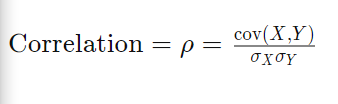

En la fórmula podemos ver que la correlación entre dos variables se obtiene dividiendo la covarianza de estas entre el producto de sus desviacioens estándar.
A continuación, usaremos como base la matriz que de varianza y covarianza que se construyó para poder armar una matriz de correlaciones.

In [13]:
#Creamos la matriz de correlación a partir de la matriz de varianza y covarianza obtenida

my_corr_matrix = np.zeros((len(my_variance_covariance_matrix),len(my_variance_covariance_matrix[0]) ))
my_corr_matrix



array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [14]:
# Ahora creamos una función que, para cada valor de la matriz de varianzas, va a calcular
# la correlación entre las variables de los indices i,j de la matriz

for i in range (0, len(my_corr_matrix)):
  for j in range (0, len(my_corr_matrix)):
    #definimos la varianza actual a procesar
    variance =  my_variance_covariance_matrix[i][j]
    #obtenemos las desviaciones estandar para las variables i, j 
    std_x = my_variance_covariance_matrix[i][i] ** (1/2)
    std_y = my_variance_covariance_matrix[j][j] ** (1/2)
    #ahora aplicamos la fórmula directamente
    my_corr_matrix[i][j] = variance / (std_x * std_y)


In [15]:
# Una vez armada la matriz, la convertimos en dataframe para su mejor visualización
my_corr_matrix_df = pd.DataFrame(my_corr_matrix)
my_corr_matrix_df.transpose()

,0,1,2,3,4
0,1.000000,0.211005,-0.076056,-0.099160,-0.005024
1,0.211005,1.000000,0.059874,0.007469,-0.054473
2,-0.076056,0.059874,1.000000,-0.221721,0.116547
3,-0.099160,0.007469,-0.221721,1.000000,-0.506208
4,-0.005024,-0.054473,0.116547,-0.506208,1.000000


In [16]:
#Ahora corroboramos el resultado utilizando la función .corr de Pandas
corr = X.corr()
corr

,EPSP,OPM,LongFinancialLeverage,small?,medium?
EPSP,1.000000,0.211005,-0.076056,-0.099160,-0.005024
OPM,0.211005,1.000000,0.059874,0.007469,-0.054473
LongFinancialLeverage,-0.076056,0.059874,1.000000,-0.221721,0.116547
small?,-0.099160,0.007469,-0.221721,1.000000,-0.506208
medium?,-0.005024,-0.054473,0.116547,-0.506208,1.000000


## Análisis de outliers y leverage points

In [17]:
X_tmp = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]
y_tmp = df_analysis["ReturnOnNextQuarter"]

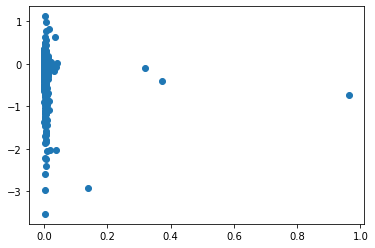

In [21]:
df_tmp = df_analysis
df_tmp['l'] = np.diagonal(np.dot(np.dot(X, np.linalg.inv(X.T @ X)), X.T))
import matplotlib.pyplot as plt
plt.scatter(df_tmp['l'], y_tmp)


## Análisis de multicolinearidad

La multicolinearidad ocurre cuando hay variables independientes que tienen correlaciones fuertes entre sí. Esto puede causar problemas en la predicción, ya que las variables que se presumen independientes terminan siendo dependientes entre sí. 

Para descartar este problema, se realiza una prueba de multicolinearidad.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()

df_vif  = df_analysis[["ReturnOnNextQuarter","EPSP","OPM", "SalesAnnualGrowth", "LongFinancialLeverage"]]

vif_data["feature"] = df_vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i)
                          for i in range(len(df_vif.columns))]

print(vif_data)

                 feature       VIF
0    ReturnOnNextQuarter  1.138614
1                   EPSP  1.074496
2                    OPM  1.055528
3      SalesAnnualGrowth  1.060669
4  LongFinancialLeverage  1.158483


En la prueba podemos ver que ninguna de las variables tiene un valor superior a 10, por lo tanto podemos descartar que haya problemas de multicolinearidad.

# Creación del modelo

A continuación, utilizaremos álgebra matricial para hacer una regresión lineal múltiple.

In [ ]:
#Definimos las variables dependientes e independientes
X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]

y = df_analysis["ReturnOnNextQuarter"]

In [ ]:
#creamos una columna para las betas
X["beta"] = 1
#Hacemos esto para colocar la columna al principio del dataframe
temp_1s_col = X["beta"]
X= X.drop("beta", axis=1)
X.insert(0,"beta", temp_1s_col)
X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,beta,EPSP,OPM,LongFinancialLeverage,small?,medium?
448,1,0.0,0.000000,0.016016,0,1
2695,1,0.0,0.000000,0.003474,1,0
3055,1,0.0,0.000000,0.404709,0,1
4135,1,0.0,0.000000,0.012156,1,0
7645,1,0.0,0.000000,0.218182,1,0
...,...,...,...,...,...,...
318054,1,0.0,0.000000,0.319127,0,1
318684,1,0.0,0.000000,0.640112,0,1
319044,1,0.0,0.000000,0.018014,0,1
319584,1,0.0,-0.346404,0.258356,1,0


In [ ]:
#Obtenemos la transpuesta de X
transposed_X = X.transpose()

In [ ]:
# Obtenemos el producto punto entre la transpuesta de X y X
transposed_X_dot_X = transposed_X.dot(X)

In [ ]:
#Obtenemos la inversa de la matriz que calculamos previamente
transposed_X_dot_X_inv = np.linalg.inv(transposed_X_dot_X)

In [ ]:
#Obtenemos el producto punto entre la transpuesta de X y Y
transposed_X_dot_Y = transposed_X.dot(y)

In [ ]:
#Finalmente, obtenemos la matriz de betas calculando el producto punot
#entre las dos últimas matrices que calculamos.
betas = transposed_X_dot_X_inv.dot(transposed_X_dot_Y)

In [ ]:
betas

array([-0.08647201,  6.05724801,  0.09681478, -0.22419559, -0.0972918 ,
       -0.04082689])

In [ ]:
#Validamos el resultado obtenido utilizando la librería OLS de statsmodel
import statsmodels.api as sm

X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]
x = sm.add_constant(X)
y = df_analysis["ReturnOnNextQuarter"]
#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ReturnOnNextQuarter   R-squared:                       0.048
Model:                             OLS   Adj. R-squared:                  0.042
Method:                  Least Squares   F-statistic:                     7.734
Date:                 Mon, 24 Oct 2022   Prob (F-statistic):           4.15e-07
Time:                         22:43:12   Log-Likelihood:                -432.31
No. Observations:                  769   AIC:                             876.6
Df Residuals:                      763   BIC:                             904.5
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
